In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
import array_sensitivity
import importlib
importlib.reload(array_sensitivity)

<module 'array_sensitivity' from '/Users/ruby/Astro/PSsensitivity/array_sensitivity.py'>

In [2]:
# Set instrument parameters
antpos_filepath = "20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = c / 0.21
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k = 25
aperture_efficiency = 0.62
field_of_view_deg2 = 10.6
antenna_diameter_m = 5
freq_resolution_hz = 162.5e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = None
bao_scales_deg = [1.5, 4.6]  # first 3 wiggles at z=0.5

In [3]:
antpos = array_sensitivity.get_antpos(antpos_filepath)

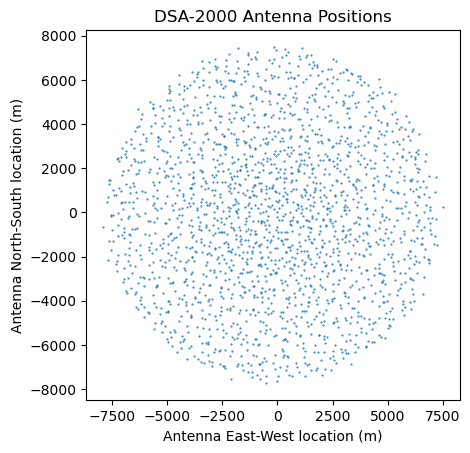

In [4]:
fig, ax = plt.subplots()
ax.plot(antpos[:,0], antpos[:,1], marker="o", markersize=.5, linewidth=0)
ax.set_aspect(1)
ax.set_xlabel("Antenna East-West location (m)")
ax.set_ylabel("Antenna North-South location (m)")
ax.set_title("DSA-2000 Antenna Positions")
ax.set_aspect("equal")
plt.savefig("plots/antlocs.png", dpi=600)
plt.show()

In [5]:
np.shape(antpos)

(2048, 2)

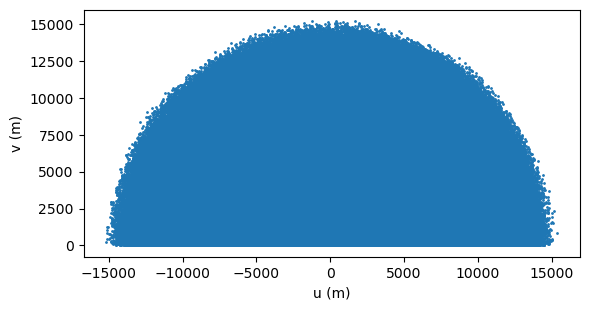

In [6]:
baselines_m = array_sensitivity.get_baselines(antpos)
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

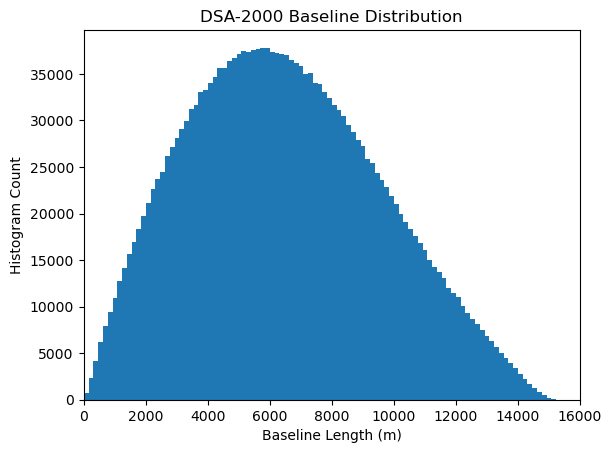

In [7]:
plt.hist(np.sqrt(np.sum(baselines_m**2., axis=1)), bins=100)
plt.xlabel("Baseline Length (m)")
plt.ylabel("Histogram Count")
plt.title("DSA-2000 Baseline Distribution")
plt.xlim([0,16000])
plt.savefig("plots/baseline_hist.png", dpi=600)
plt.show()

In [8]:
bao_scales_wl = (1 / np.sin(np.radians(bao_scales_deg)))[::-1]
print(bao_scales_wl)
kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
bao_scales_k = kperp_conv_factor * bao_scales_wl
print(bao_scales_k)

[12.46899517 38.20155001]
[0.01250207 0.03830289]


In [9]:
min_baseline_wl = np.min(np.sqrt(np.sum(baselines_m**2., axis=1))) * freq_hz / c
print(min_baseline_wl)

31.39572164525647


In [27]:
freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)
delay_array_s = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array_hz), d=freq_resolution_hz)
)
print(np.max(delay_array_s))
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
max_kpar = kpar_conv_factor * np.max(delay_array_s)
print(max_kpar)
max_baseline_wl = np.max(np.sqrt(np.sum(baselines_m**2., axis=1))) * max_freq_hz / c
max_kperp = kperp_conv_factor * max_baseline_wl
print(max_kperp)
max_k = np.sqrt(max_kpar**2. + max_kperp**2.)

3.0755506759075002e-06
6.006241515164992
73.49742968326642


In [11]:
# Define bin edges:
k_bin_size = .2
bin_edges = np.arange(0, max_k, k_bin_size)
n_kbins = len(bin_edges) - 1

kpar_bin_edges = np.arange(0, max_kpar, k_bin_size)
kperp_bin_edges = np.arange(0, max_kperp, k_bin_size)

In [12]:
(
    nsamples,
    binned_ps_variance,
    true_bin_edges,
    true_bin_centers,
    nsamples_2d,
    binned_ps_variance_2d,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    zenith_angle=0.
)

/Users/ruby/Astro/PSsensitivity/array_sensitivity.py:294: RuntimeWarning: divide by zero encountered in true_divide
  binned_ps_variance_2d = ps_variance / nsamples_2d
/Users/ruby/Astro/PSsensitivity/array_sensitivity.py:324: RuntimeWarning: divide by zero encountered in true_divide
  binned_ps_variance = ps_variance / nsamples


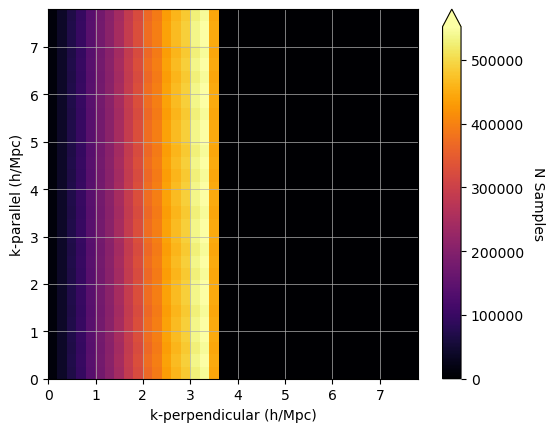

In [13]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    nsamples_2d.T,
    origin="lower",
    interpolation="none",
    extent=[np.min(kperp_bin_edges), np.max(kperp_bin_edges), np.min(kpar_bin_edges), np.max(kpar_bin_edges)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("k-perpendicular (h/Mpc)")
ax.set_ylabel("k-parallel (h/Mpc)")
#ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("N Samples", rotation=270, labelpad=15)
plt.show()

In [14]:
# Load CAMB power spectrum data
f = open("camb_49591724_matterpower_z0.5.dat", "r")
file_data = f.readlines()
f.close()
model_k_axis = []
ps_model_unnorm = []
for line in file_data:
    model_k_axis.append(float(line.split()[0]))
    ps_model_unnorm.append(float(line.split()[1]))
ps_model = array_sensitivity.matter_ps_to_21cm_ps_conversion(
    np.array(model_k_axis),
    np.array(ps_model_unnorm),
    0.5
)

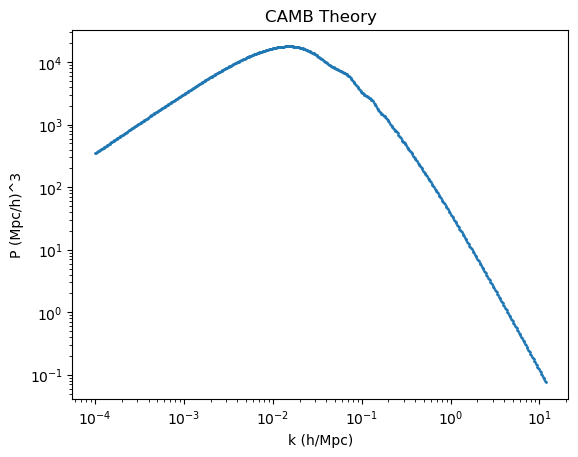

In [15]:
plt.scatter(model_k_axis, ps_model_unnorm, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k (h/Mpc)")
plt.ylabel("P (Mpc/h)^3")
plt.title("CAMB Theory")
#plt.xlim([1e-2,1e0])
plt.show()

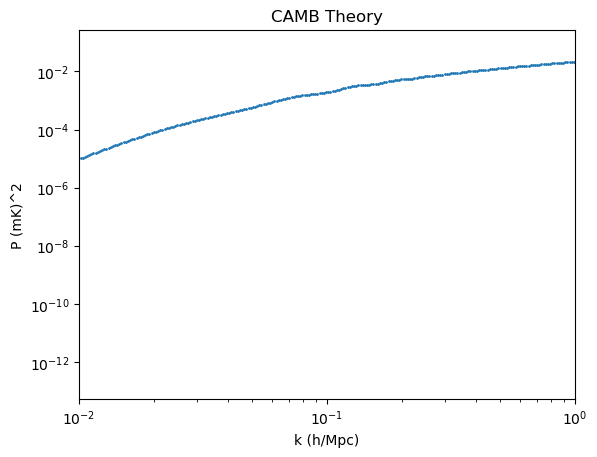

In [16]:
plt.scatter(model_k_axis, ps_model, s=1)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k (h/Mpc)")
plt.ylabel("P (mK)^2")
plt.title("CAMB Theory")
plt.xlim([1e-2,1e0])
plt.show()

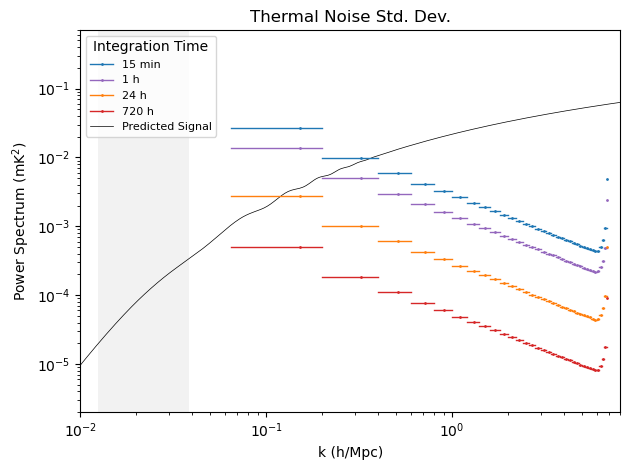

In [17]:
plot_integration_times_h = [.25, 1, 24, 720]
colors = ['tab:blue','tab:purple','tab:orange','tab:red']
legend_labels = [
    "15 min",
    "1 h",
    "24 h",
    "720 h",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for int_time_ind, int_time in enumerate(plot_integration_times_h):
    plot_vals = np.sqrt(binned_ps_variance * .25 / int_time)
    plt.plot(
        true_bin_centers,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[int_time_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[int_time_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Integration Time")
plt.title("Thermal Noise Std. Dev.")
plt.tight_layout()
plt.savefig("plots/thermal_noise_stddev.png")
plt.show()

In [18]:
uv_extent = 4000
sample_variance_cube, binned_ps_sample_variance = array_sensitivity.get_sample_variance(
    ps_model,  # Units mK^2
    model_k_axis,  # Units h/Mpc
    uv_extent=uv_extent,
    field_of_view_deg2=field_of_view_deg2,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    freq_resolution_hz=freq_resolution_hz,
    k_bin_edges=bin_edges,
)

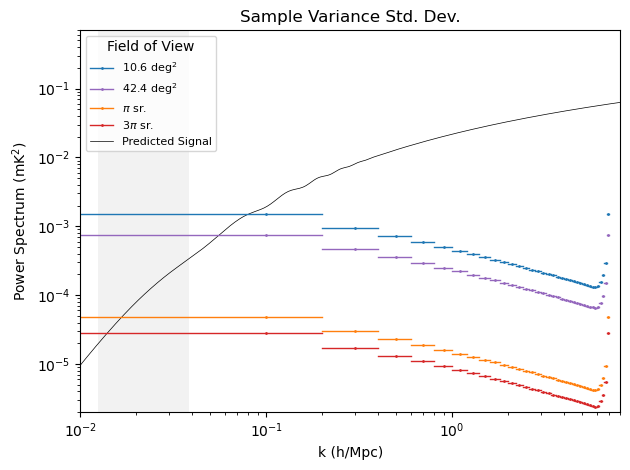

In [19]:
plot_fov_deg = [10.6, 42.4, np.pi*(180/np.pi)**2., 3*np.pi*(180/np.pi)**2.]
colors = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:red']
legend_labels = [
    "10.6 deg$^2$",
    "42.4 deg$^2$",
    "$\pi$ sr.",
    "3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")] 

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for fov_ind, use_fov in enumerate(plot_fov_deg):
    plot_vals = np.sqrt(binned_ps_sample_variance * field_of_view_deg2 / use_fov)
    plt.plot(
        (bin_edges[:-1] + bin_edges[1:]) / 2,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[fov_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            [bin_edges[bin_ind], bin_edges[bin_ind + 1]],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[fov_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Field of View")
plt.title("Sample Variance Std. Dev.")
plt.tight_layout()
plt.savefig("plots/sample_stddev.png")
plt.show()

In [20]:
combined_variance_single_field = binned_ps_variance + binned_ps_sample_variance
combined_variance_all_sky = (
    (binned_ps_variance * .25 / 720) 
    + (binned_ps_sample_variance * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

In [21]:
print(np.sqrt(binned_ps_variance[0]))
print(np.sqrt(binned_ps_sample_variance[0]))

0.027045778498486044
0.0015014584918248562


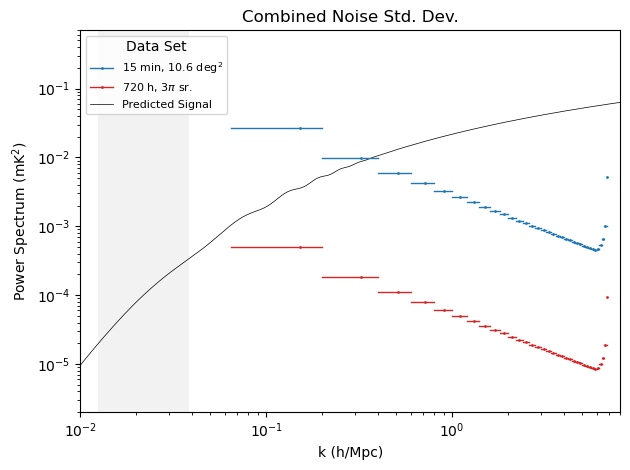

In [22]:
colors = ['tab:blue', 'tab:red']
legend_labels = [
    "15 min, 10.6 deg$^2$",
    "720 h, 3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for data_ind, plot_vals in enumerate(np.sqrt([combined_variance_single_field, combined_variance_all_sky])):
    plt.plot(
        true_bin_centers,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[data_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[data_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Data Set")
plt.title("Combined Noise Std. Dev.")
plt.tight_layout()
plt.savefig("plots/combined_noise_stddev.png")
plt.show()

# Off-Zenith Analysis
Look at a zenith angle of 60 degrees

In [23]:
(
    nsamples_offzenith,
    binned_ps_variance_offzenith,
    true_bin_edges_offzenith,
    true_bin_centers_offzenith,
    nsamples_2d_offzenith,
    binned_ps_variance_2d_offzenith,
) = array_sensitivity.delay_ps_sensitivity_analysis(
    antpos_filepath=antpos_filepath,
    min_freq_hz=min_freq_hz,
    max_freq_hz=max_freq_hz,
    tsys_k=tsys_k,
    aperture_efficiency=aperture_efficiency,
    antenna_diameter_m=antenna_diameter_m,
    freq_resolution_hz=freq_resolution_hz,
    int_time_s=int_time_s,
    max_bl_m=max_bl_m,
    k_bin_edges_1d=bin_edges,
    kpar_bin_edges=kpar_bin_edges,
    kperp_bin_edges=kperp_bin_edges,
    zenith_angle=60.
)

In [24]:
combined_variance_single_field_offzenith = binned_ps_variance_offzenith + binned_ps_sample_variance
combined_variance_all_sky_offzenith = (
    (binned_ps_variance_offzenith * .25 / 720) 
    + (binned_ps_sample_variance * field_of_view_deg2 / (3*np.pi*(180/np.pi)**2.))
)

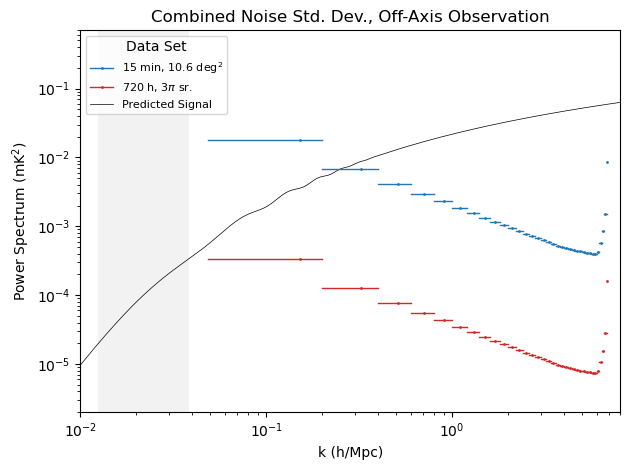

In [25]:
colors = ['tab:blue', 'tab:red']
legend_labels = [
    "15 min, 10.6 deg$^2$",
    "720 h, 3$\pi$ sr.",
    "Predicted Signal",
]
xrange = [1e-2, 8]
yrange = [2e-6, 7e-1]

legend_lines = [Line2D([0], [0], linewidth=1, marker="o", markersize=1, color=color) for color in colors]
legend_lines = legend_lines + [Line2D([0], [0], linewidth=0.5, marker="none", color="black")]

# Plot theory line
plt.plot(model_k_axis, ps_model, color="black", marker="none", linewidth=0.5)

# Plot BAO scales
plt.fill_between(bao_scales_k, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color="grey", alpha=.1, linewidth=0)

for data_ind, plot_vals in enumerate(np.sqrt([combined_variance_single_field_offzenith, combined_variance_all_sky_offzenith])):
    plt.plot(
        true_bin_centers_offzenith,
        plot_vals,
        marker="o", markersize=1, linewidth=0,
        color=colors[data_ind],
    )
    for bin_ind in range(len(plot_vals)):  
        plt.plot(
            true_bin_edges_offzenith[bin_ind, :],
            [plot_vals[bin_ind], plot_vals[bin_ind]],
            marker="none",
            linewidth=1,
            color=colors[data_ind],
        )
plt.yscale("log")
plt.xscale("log")
plt.xlim(xrange)
plt.ylim(yrange)
plt.xlabel("k (h/Mpc)")
plt.ylabel("Power Spectrum (mK$^2$)")
plt.legend(legend_lines, legend_labels, prop={'size': 8}, title="Data Set")
plt.title("Combined Noise Std. Dev., Off-Axis Observation")
plt.tight_layout()
plt.savefig("plots/combined_noise_stddev_offzenith.png")
plt.show()